In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xlrd
girl, boy = np.loadtxt(fname='girl.txt'),np.loadtxt('boy.txt')
girlY, boyY =np.ones(girl.shape[0]), np.zeros(165)
X, Y = np.vstack((boy, girl)), np.hstack((boyY, girlY))
sheet = xlrd.open_workbook("fm_2018.xlsx").sheets()[0]
X1,X2,X3= sheet.col_values(0),sheet.col_values(1),sheet.col_values(2)
X_test = np.array([X1,X2,X3]).T
X_test, y_test = X_test[1:,:], np.array(sheet.col_values(3))[1:]
y_test = np.array(y_test=="女",dtype="float64")
X_test, Y = X_test.astype("float64"), Y.astype('float64')

In [30]:
def bayer1d(i):
    from sklearn.naive_bayes import GaussianNB
    models = (GaussianNB(priors = [0.1, 0.9]),
               GaussianNB(priors=[0.5,0.5]),
               GaussianNB(priors=[0.25,0.75]),
               GaussianNB(priors=[0.75,0.25])) 
    models = [clf.fit(X[:,i].reshape(-1,1), Y) for clf in models]
    # scores
    scores = [model.score(X_test[:,i].reshape(-1,1), y_test) for model in models]
    print("R_squre")
    print(scores)
    s = [sum(model.predict(X_test[:,i].reshape(-1,1))==y_test)/len(y_test) for model in models]
    print("accuracy")
    print(s)
    # title for the plots
    titles = ('priors = [0.1, 0.9]',
              'priors=[0.5,0.5]',
              'priors=[0.25,0.75]',
              'priors=[0.75,0.25]')
    labels = ("height","weight","size of feet")
    print(labels[i])
    fig, sub = plt.subplots(2, 2)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    from playML.metrics import roc
    from sklearn.metrics import roc_curve
    for clf, title,ax in zip(models, titles, sub.flatten()):
        fprs = []
        tprs = []
        
        decision_scores = clf.predict_proba(X_test[:,i].reshape(-1,1))
        decision_scores=decision_scores[:,0]-decision_scores[:,1]
        fprs, tprs,t  = roc_curve( y_test, decision_scores)
#         fprs, tprs,t  = roc(decision_scores, y_test)
        ax.plot(tprs, fprs,linewidth=6)
        ax.set_xlabel("fprs  "+labels[i])
        ax.set_ylabel("tprs")
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)

R_squre
[0.7674418604651163, 0.8604651162790697, 0.7906976744186046, 0.8604651162790697]
accuracy
[0.7674418604651163, 0.8604651162790697, 0.7906976744186046, 0.8604651162790697]
height
R_squre
[0.6744186046511628, 0.813953488372093, 0.7906976744186046, 0.7674418604651163]
accuracy
[0.6744186046511628, 0.813953488372093, 0.7906976744186046, 0.7674418604651163]
weight
R_squre
[0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9302325581395349]
accuracy
[0.9534883720930233, 0.9534883720930233, 0.9534883720930233, 0.9302325581395349]
size of feet


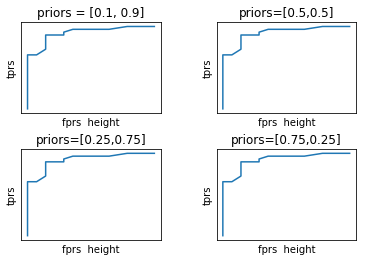

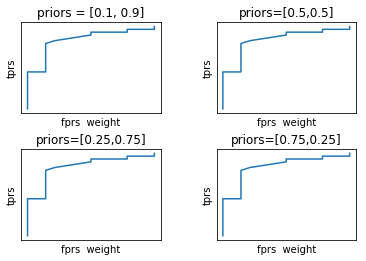

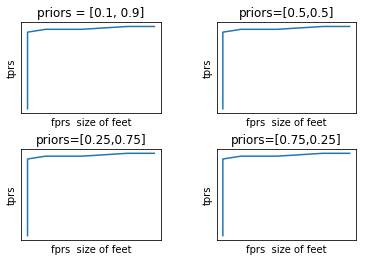

In [31]:
bayer1d(0)
bayer1d(1)
bayer1d(2)

In [43]:
def bayer1d(i):
#     from playML.Bayers import BayersGN
    models = (BayersGN(priors = [0.1, 0.9]),
               BayersGN(priors=[0.5,0.5]),
               BayersGN(priors=[0.25,0.75]),
               BayersGN(priors=[0.75,0.25]))
    models = [clf.fit(X[:,i], Y) for clf in models]
    # scores
    scores = [model.score(X_test[:,i], y_test) for model in models]
    print("R_squre")
    print(scores)
    s = [sum(model.predict(X_test[:,i])==y_test)/len(y_test) for model in models]
    print("accuracy")
    print(s)
    # title for the plots
    titles = ('priors = [0.1, 0.9]',
              'priors=[0.5,0.5]',
              'priors=[0.25,0.75]',
              'priors=[0.75,0.25]')
    labels = ("height","weight","size of feet")
    print(labels[i])
    fig, sub = plt.subplots(1, 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    from playML.metrics import roc
    from sklearn.metrics import roc_curve
    fprs = []
    tprs = []

    decision_scores = models[0].decision_function(X_test[:,i])
    fprs, tprs,t  = roc_curve( y_test, decision_scores)

#         fprs, tprs,t  = roc(decision_scores, y_test)
    sub.plot(fprs, tprs)
    sub.set_xlabel("fprs")
    sub.set_ylabel("tprs")
    sub.set_xticks(())
    sub.set_yticks(())
    sub.set_title(titles[0])

R_squre
[-2.0714285714285716, -0.48275862068965547, -2.0714285714285716, -0.48275862068965547]
accuracy
[0.32558139534883723, 0.6744186046511628, 0.32558139534883723, 0.6744186046511628]
height
R_squre
[-2.0714285714285716, -2.0714285714285716, -2.0714285714285716, -0.48275862068965547]
accuracy
[0.32558139534883723, 0.32558139534883723, 0.32558139534883723, 0.6744186046511628]
weight
R_squre
[-0.9064039408866997, -0.37684729064039413, 0.7881773399014778, -0.48275862068965547]
accuracy
[0.5813953488372093, 0.6976744186046512, 0.9534883720930233, 0.6744186046511628]
size of feet


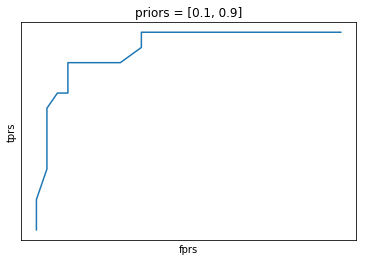

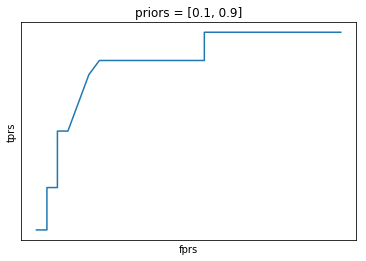

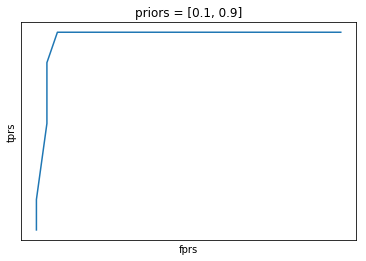

In [44]:
bayer1d(0)
bayer1d(1)
bayer1d(2)

In [32]:
import numpy as np
from numpy.linalg import inv

from playML.metrics import r2_score


class BayersGN:
    def __init__(self, priors=[0.5, 0.5]):
        """初始化Linear Regression模型"""
        self.priors = priors
        self._mean = None
        self._cov = None

    def fit(self, X_train, y_train):
        """
        sorted_y 和priors对应的类别序号相对应
        """
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        sorted_y = np.sort(np.unique(y_train))
        self._mean = [X_train[y_train == y].mean(axis=0) for y in sorted_y]
        self._cov = [np.cov(X_train[y_train == y].T) for y in sorted_y]
        return self

    def predict(self, X_predict):
        """给定带预测数据集X_predict,返回表示X_predict的结果向量"""
        y_predict = [self._predict(x) for x in X_predict]
        return np.array(y_predict)

    def _predict(self, Xi):
        return np.argsort(self._rvs_g(Xi))[0]

    def decision_function(self, X_test):
        b = [self._rvs_g(X_test[i])[0]-self._rvs_g(X_test[i])[1] for i in range(len(X_test))]
        return np.array(b)

    def score(self, X_test, y_test):
        """根据数据集X_test，y_test计算准确度 默认为r2_score"""
        y_predict = self.predict(X_test)
        return r2_score(y_test, y_predict)

    def _rvs_g(self, Xi):
        if self._cov[0].ndim == 0:
            rvs_g = [(Xi - self._mean[i]) / self._cov[i] + np.log(self._cov[i]) - 2 * np.log(self.priors[i]) for i in
                     range(len(self._mean))]
        else:
            rvs_g = [np.matmul(np.matmul((Xi - self._mean[i]), inv(self._cov[i])),
                               (Xi - self._mean[i])) +
                     np.log(np.linalg.det(self._cov[i])) - 2 * np.log(self.priors[i]) for i in range(len(self._mean))]
        return rvs_g
